# CROP-seq KO15 - Mixscape cells only - Normalization, Confounding Factor Analysis and Unsupervised Analysis
- input: filtered & annotated Seurat object + mixscape annotations
- output: PCA & UMAP plots

In [1]:
# set correct working directory -> project folder
getwd()
setwd('..')
getwd()

[1] "/home/sreichl/projects/bmdm-stim/src"

[1] "/home/sreichl/projects/bmdm-stim"

In [2]:
# load libraries

# for Seurat (limma via conda install)
library(dplyr)
library(Seurat) # installed via conda install (conda forge channel)
library(patchwork)
library(ggplot2)
library(DESeq2)
library(cowplot)
library(glmGamPoi) # for faster sctransform

# for gene list converter
# library(biomaRt)

# for Upset plots
library(UpSetR)
library(fastDummies)

# for volcano plots
library(EnhancedVolcano)

library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, 

In [3]:
# configs
data_path <- file.path('results','KO15')
results_path <- file.path(data_path, 'unsupervised_mixscape')

In [4]:
# make directories if not exist
dir.create(results_path, showWarnings = FALSE)

# load filtered and annotated data

In [5]:
# loading Seurat object
KO15 <-readRDS(file = file.path(data_path,paste0("KO15_filtered_Seurat.rds")))
KO15

An object of class Seurat 
31135 features across 9153 samples within 4 assays 
Active assay: RNA (31053 features, 0 variable features)
 3 other assays present: AB, gRNA, HTO

# prepare metadata

In [7]:
KO15[['condition']] <- str_split_fixed(KO15$hto_demux, "_", 2)[,2]
unique(KO15$condition)

[1] "LO28_2h"   "untreated" "LO28_6h"

# load mixscape annotation & filter data

In [8]:
keep_idx <- c()

# mixscape-condition-wise analysis results
for (cond in unique(KO15$condition)){
    tmp_cond <- read.csv(file=file.path(data_path,'mixscape',cond,'KO15_mixscape_annotations.csv'), row.names=1)
    cond_idx <- rownames(tmp_cond)[(tmp_cond$mixscape_class.global=='KO') | (tmp_cond$mixscape_class.global=='NT')]
    keep_idx <- c(keep_idx,cond_idx)
}

# mixscape_all analysis resutls
#     mixscape_annot <- read.csv(file=file.path(data_path,'mixscape','all','KO15_mixscape_annotations.csv'), row.names=1)
#     keep_idx <- rownames(mixscape_annot)[(mixscape_annot$mixscape_class.global=='KO') | (mixscape_annot$mixscape_class.global=='NT')]

print(length(keep_idx))

KO15 <- subset(KO15, cells = keep_idx)

[1] 4978


# normalize RNA via SCTransform, AB & guideRNA via CLR

In [9]:
dir.create(file.path(results_path,"cellcycle"), showWarnings = FALSE)

In [10]:
DefaultAssay(KO15) 
DefaultAssay(KO15) <- 'RNA'
DefaultAssay(KO15) 

[1] "RNA"

[1] "RNA"

In [11]:
# run sctransform
KO15 <- SCTransform(KO15, 
                     vars.to.regress = "percent.mt", 
                     verbose = FALSE,
                     method = "glmGamPoi"
                    )#, min_cells = 1)

In [12]:
mouseHumanGenes <- read.table(file = file.path("resources","HOM_MouseHumanSequence.rpt"), sep = '\t', header = TRUE)

In [13]:
# convert human cell cycle genes to murine genes
m.g2m.genes <- vector()

for (human_gene in cc.genes$g2m.genes){
    tmp_homolo_ID <- mouseHumanGenes[mouseHumanGenes$Symbol==human_gene,'HomoloGene.ID']
    m.g2m.genes <- append(m.g2m.genes, mouseHumanGenes[mouseHumanGenes$HomoloGene.ID==tmp_homolo_ID & mouseHumanGenes$Common.Organism.Name=="mouse, laboratory", "Symbol"])
}

# m.g2m.genes

In [14]:
# convert human cell cycle genes to murine genes
m.s.genes <- vector()

for (human_gene in cc.genes$s.genes){
    tmp_homolo_ID <- mouseHumanGenes[mouseHumanGenes$Symbol==human_gene,'HomoloGene.ID']
    m.s.genes <- append(m.s.genes, mouseHumanGenes[mouseHumanGenes$HomoloGene.ID==tmp_homolo_ID & mouseHumanGenes$Common.Organism.Name=="mouse, laboratory", "Symbol"])
}

# m.s.genes

In [15]:
DefaultAssay(KO15)

[1] "SCT"

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 16 features requested have not been scaled (running reduction without them): Wdr76, Ubr7, Pold3, Msh2, Cdc45, Dscc1, Blm, Pola1, Brip1, Ckap2, Bub1, Gtse1, Lbr, Ctcf, G2e3, Cbx5”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  Ung, Cdc6, Ccne2, Cdca7, Casp8ap2, Mcm6, Dtl, Chaf1b, Mcm2, Mcm4 
	   Pcna, Gins2, Gas2l3, Uhrf1, Slbp, Prim1, Exo1, Hells, Rfc2, Mcm5 
	   E2f8, Rad51, Rad51ap1, Nasp, Rpa2, Gmnn, Clspn, Psrc1, Atad2, Hjurp 
Negative:  Ube2c, Hmgb2, Mki67, Tubb4b, Top2a, Cenpf, Cenpa, Birc5, Ccnb2, Cdc20 
	   Tpx2, Cdk1, Cdca8, Aurkb, Cenpe, Kif23, Cks1b, Smc4, Aurka, Nusap1 
	   Kif11, Ckap2l, Tacc3, Hmmr, Kif20b, Anln, Cdca3, Tmpo, Cdca2, Cks2 
PC_ 2 
Positive:  Ube2c, Cenpa, Cdc20, Ccnb2, Cenpf, Tubb4b, Cenpe, Cks2, Aurka, Cdc25c 
	   Hmmr, Kif2c, Psrc1,

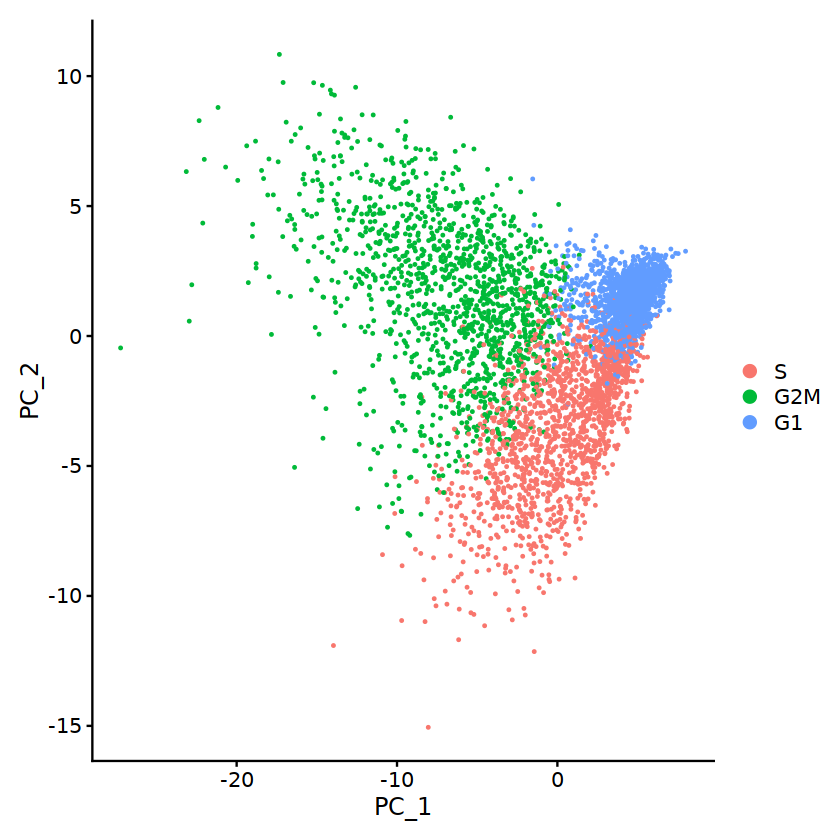

In [16]:
# determine cell cycle scores and plot
s.genes <- m.s.genes
g2m.genes <- m.g2m.genes
KO15 <- CellCycleScoring(KO15, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE) #presumably running on SCT assay, as it is the default Assay
KO15 <- RunPCA(KO15, features = c(s.genes, g2m.genes))
DimPlot(KO15)
ggsave(
  paste0("KO15_","CellCyclePCA","_","preRemoval", ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path,"cellcycle"),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 16 features requested have not been scaled (running reduction without them): Wdr76, Ubr7, Pold3, Msh2, Cdc45, Dscc1, Blm, Pola1, Brip1, Ckap2, Bub1, Gtse1, Lbr, Ctcf, G2e3, Cbx5”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  Mki67, Top2a, Kif11, Aurkb, Rrm2, Atad2, Tmpo, Anln, Cdca2, Rrm1 
	   Ncapd2, Smc4, E2f8, Ttk, Nuf2, Clspn, Ckap2l, Ndc80, Nusap1, Tyms 
	   Hmgb2, Kif20b, Hjurp, Rad51ap1, Kif23, Prim1, Ckap5, Chaf1b, Rad51, Ccne2 
Negative:  Ube2c, Cdc20, Cenpa, Ccnb2, Tubb4b, Ung, Cdca7, Aurka, Cks1b, Cenpf 
	   Hells, Mcm2, Nasp, Kif2c, Cdk1, Rpa2, Cdc25c, Nek2, Dtl, Tacc3 
	   Mcm6, Birc5, Mcm4, Mcm5, Psrc1, Cdc6, Casp8ap2, Hmmr, Gins2, Tpx2 
PC_ 2 
Positive:  Ccnb2, Cdc20, Cenpa, Hmgb2, Cdca3, Cdca8, Cks2, Psrc1, Birc5, Cks1b 
	   Cdca7, Cenpe, Nasp, C

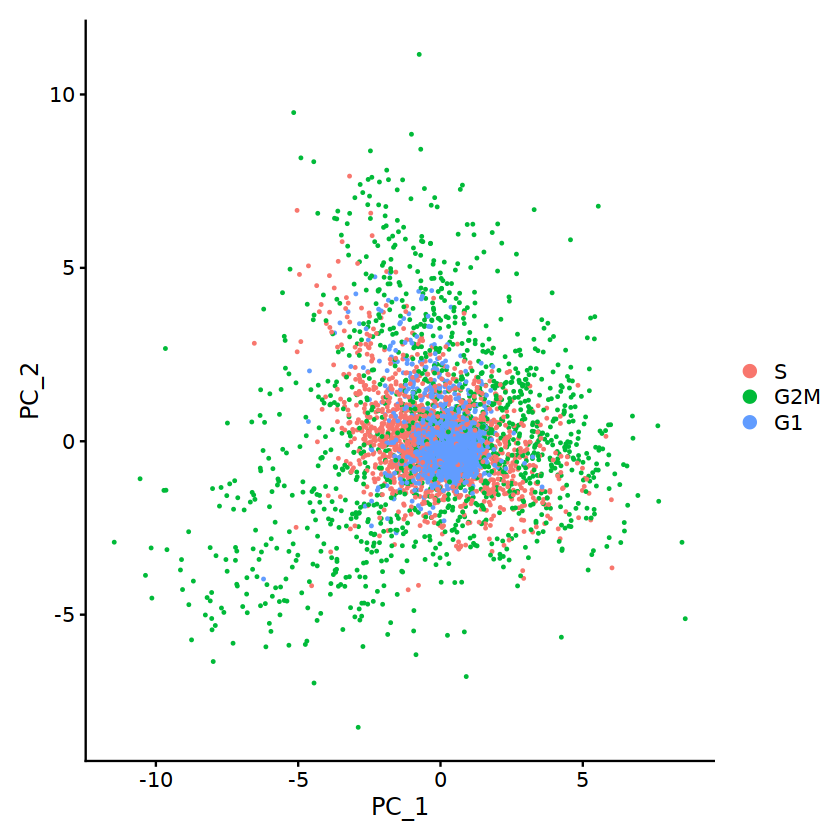

In [17]:
KO15 <- SCTransform(KO15, 
                     vars.to.regress = c("percent.mt", "S.Score", "G2M.Score"), 
                     assay = 'RNA', 
                     new.assay.name = 'SCT', 
                     verbose = FALSE,
                     method="glmGamPoi"
                    )#, min_cells = 1)
KO15 <- RunPCA(KO15, features = c(s.genes, g2m.genes))
DimPlot(KO15)
ggsave(
  paste0("KO15_","CellCyclePCA","_","postRemoval", ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path,"cellcycle"),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [18]:
# normalize Ab data
KO15 <- NormalizeData(KO15, normalization.method = "CLR", margin = 2, assay = "AB")

Normalizing across cells



In [19]:
# normalize guide RNA data
KO15 <- NormalizeData(KO15, normalization.method = "CLR", margin = 2, assay = "gRNA")

Normalizing across cells



# Dimred & plot

In [20]:
# Run PCA & UMAP
KO15 <- RunPCA(KO15, verbose = FALSE)
KO15 <- RunUMAP(KO15, dims = 1:30, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [21]:
# Plot PCA & UMAP with discrete features (Dimplot)
features <- c("hto_demux", "batch", "KO_call", "Phase", "condition")

for (dimred in c("umap", "pca")){
    for (feature in features){
        if (feature=='KO_call'){
                DimPlot(KO15, reduction=dimred, label = FALSE, group.by=feature) + NoLegend()
        }else{
                DimPlot(KO15, reduction=dimred, label = FALSE, group.by=feature)
        }
#         DimPlot(KO15, reduction=dimred, label = FALSE, group.by=feature)
        ggsave(
          paste0("KO15_normalized_",dimred,"_",feature, ".svg"),
          plot = last_plot(),
          device = "svg",
          path = file.path(results_path),
          scale = 1,
          dpi = 300,
          limitsize = FALSE,
        )
    }
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [23]:
# Plot PCA & UMAP colored by NT and Spi1-KO

KO15$NT_Spi1 <- KO15$KO_call
KO15$NT_Spi1[(KO15$NT_Spi1!='mSpi1') & (KO15$NT_Spi1!='mNon-targeting')] <- 'other'
unique(KO15$NT_Spi1)

for (dimred in c("umap", "pca")){
    DimPlot(KO15, reduction=dimred, label = FALSE, group.by='NT_Spi1', cells = KO15$NT_Spi1!='other')

    ggsave(
      paste0("KO15_normalized_",dimred,"_NT_Spi1-KO", ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

[1] "other"          "mNon-targeting" "mSpi1"

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [24]:
# Plot PCA & UMAP with continuous features (FeaturePlot)
features <- c("nCount_RNA", "nFeature_RNA", "nCount_AB", 'nFeature_AB','nCount_gRNA','nFeature_gRNA','nCount_HTO','nFeature_HTO','percent.mt')

for (dimred in c("umap", "pca")){
    for (feature in features){
        FeaturePlot(KO15, reduction=dimred, features = feature)
        ggsave(
          paste0("KO15_normalized_",dimred,"_",feature, ".svg"),
          plot = last_plot(),
          device = "svg",
          path = file.path(results_path),
          scale = 1,
          dpi = 300,
          limitsize = FALSE,
        )
    }
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [25]:
# Plot PCA & UMAP with all continuous features (FeaturePlot)
for (dimred in c("umap", "pca")){
    FeaturePlot(KO15, reduction=dimred, features = features)
    ggsave(
      paste0("KO15_normalized_",dimred,"_all", ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
        width=20,
        height=20
    )
}

In [6]:
# Plot PCA & UMAP with all AB features simultaneously (FeaturePlot)
features <- rownames(GetAssayData(object = KO15, assay='AB', slot = "counts"))

for (dimred in c("umap", "pca")){
    FeaturePlot(KO15, reduction=dimred, features = features)
    ggsave(
      paste0("KO15_AB_normalized_",dimred,"_all", ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
        width=20,
        height=20
    )
}

Warning message:
“Could not find CD115 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD11b in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD274 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD69 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD64 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD163 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD172a in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD14 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD80 in the default search locations, found in AB assay instead”
Warning message:
“Could not find Mac-2 in the default search locations, found in AB assay instead”
Warning messa

# save & load normalized Seurat object

In [26]:
# save Seurat object
saveRDS(KO15, file = file.path(results_path,paste0("KO15_normalized_Seurat.rds")))

In [4]:
# loading Seurat object
KO15 <-readRDS(file = file.path(results_path,paste0("KO15_normalized_Seurat.rds")))
KO15

An object of class Seurat 
44530 features across 4978 samples within 5 assays 
Active assay: SCT (13395 features, 3000 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 2 dimensional reductions calculated: pca, umap

In [28]:
# save matrix of SCT counts
SCT_counts <- GetAssayData(object = KO15, slot = "counts")
dim(SCT_counts)
write.csv(SCT_counts, file=file.path(results_path,paste0('KO15_SCT_counts','.csv')), row.names=TRUE)

[1] 13395  4978

In [8]:
# save metadata & normalized AB values
slot <- "data"
ab_flag <- "AB"
step <- "NORMALIZED"

# save metadata
write.csv(KO15[[]], file=file.path(results_path, paste0('KO15_',step,"_metadata",".csv")), row.names=TRUE)
# save normalized AB
write.csv(GetAssayData(object = KO15, slot = slot, assay = ab_flag), file=file.path(results_path, paste0('KO15_',step,'_',ab_flag,".csv")), row.names=TRUE)

# make cell count summary

In [29]:
cell_numbers_df <- data.frame(matrix(ncol = 3, nrow=length(unique(KO15$KO_call))+1))
rownames(cell_numbers_df) <- c('all',unique(KO15$KO_call))
colnames(cell_numbers_df) <- unique(KO15$condition)

In [30]:
# load, extract and save cell numbers per object
for (condition in unique(KO15$condition)){
#     print(condition)
    
    # fill in sums of all cells
    cell_numbers_df['all',condition] <- sum(KO15$condition==condition)
    
    # fill in NT cells
    cell_numbers_df['mNon-targeting', condition] <- sum(KO15$condition==condition & KO15$KO_call=='mNon-targeting')
    
    for (KO_gene in unique(KO15$KO_call)){
        if (KO_gene=='mNon-targeting'){
            next
        }
        cell_numbers_df[KO_gene, condition] <- sum(KO15$condition==condition & KO15$KO_call==KO_gene)
    }
}

head(cell_numbers_df)

,LO28_2h,untreated,LO28_6h
,<int>,<int>,<int>
all,1642,1508,1828
mStat1,91,106,177
mIrf9,274,304,263
mNon-targeting,309,262,270
mStat2,185,190,172
mRela,106,0,69


In [31]:
write.csv(cell_numbers_df, file=file.path(results_path,paste0('KO15_cell_count_summary','.csv')), row.names=TRUE)

In [32]:
sum(cell_numbers_df==0)

[1] 3

In [33]:
rowSums(cell_numbers_df)[1]

all 
4978

In [36]:
mean(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','mNon-targeting')),'untreated'])
mean(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','mNon-targeting')),'LO28_2h'])
mean(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','mNon-targeting')),'LO28_6h'])

[1] 42.71429

[1] 57.10714

[1] 14.14286

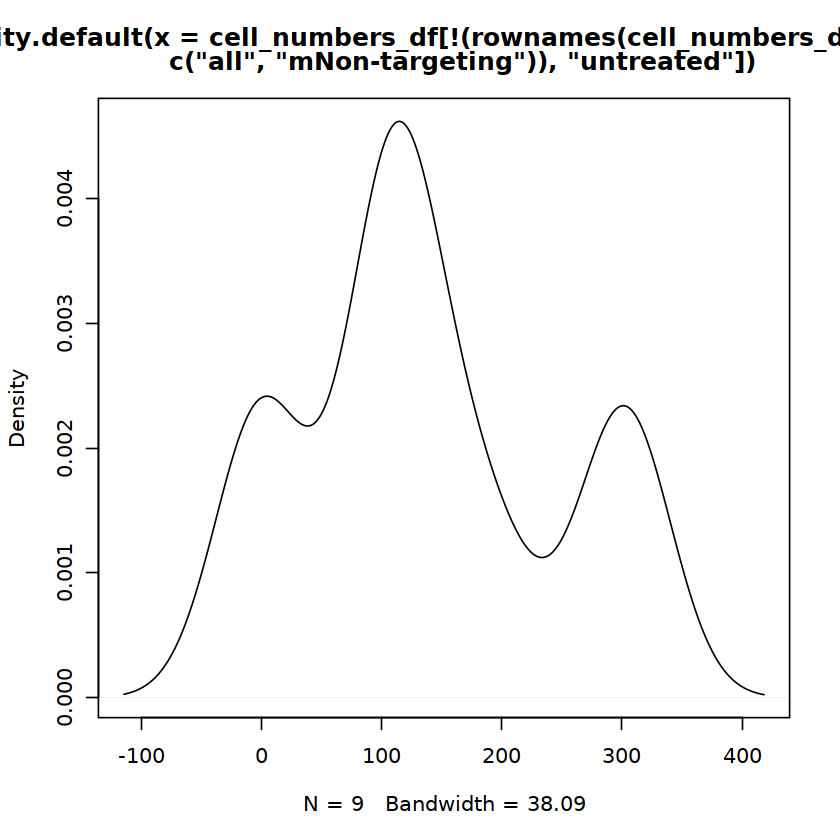

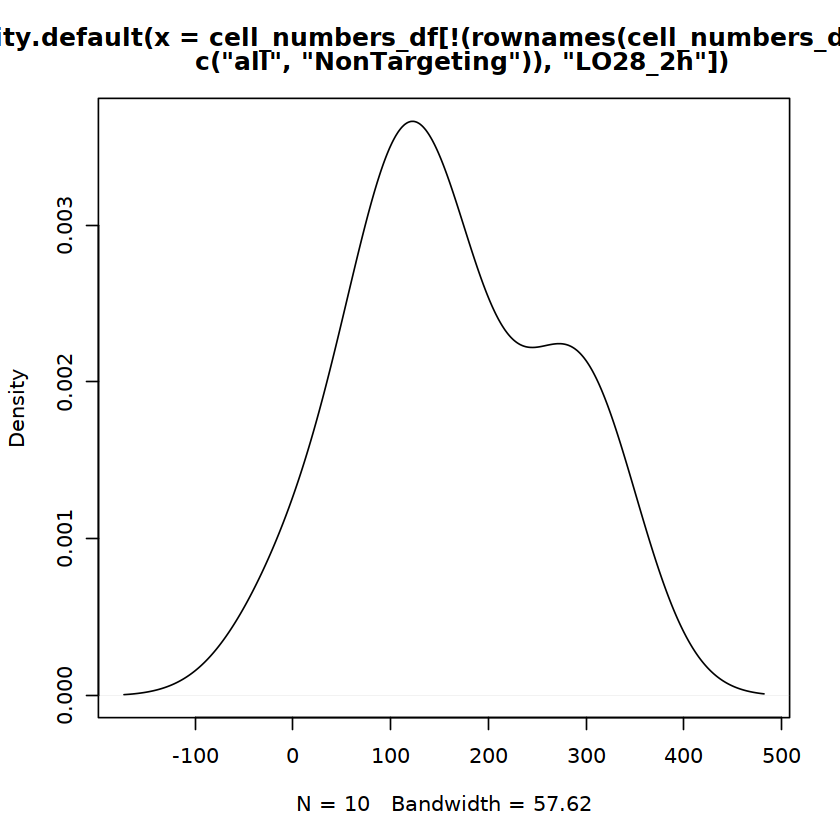

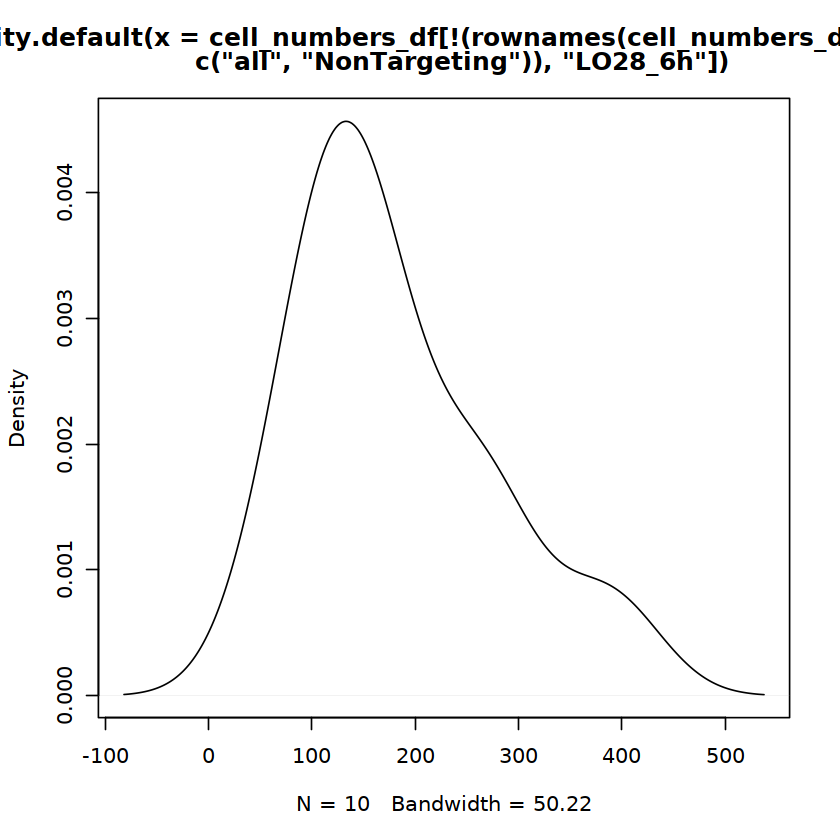

In [34]:
plot(density(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','mNon-targeting')),'untreated']))
plot(density(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','NonTargeting')),'LO28_2h']))
plot(density(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','NonTargeting')),'LO28_6h']))

# interactive plot

In [35]:
library(plotly)


Attaching package: ‘plotly’


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




In [36]:
plot <- DimPlot(KO15, reduction='umap', label = FALSE, group.by='condition')
p <- HoverLocator(plot = plot, information = FetchData(KO15, vars = colnames(KO15[[]])))#c("batch", "KO_call", "guide_call", "nFeature_RNA",'nCount_RNA','Phase', 'condition')))

In [37]:
htmlwidgets::saveWidget(as_widget(p), file.path(results_path,"index.html"))

Warning message in if (is.na(col)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(col)) {:
“the condition has length > 1 and only the first element will be used”
Warning message:
“`error_y.color` does not currently support multiple values.”
Warning message:
“`error_x.color` does not currently support multiple values.”
Warning message:
“`line.color` does not currently support multiple values.”
Warning message:
“The titlefont attribute is deprecated. Use title = list(font = ...) instead.”
